<a href="https://colab.research.google.com/github/ChristeenTJose/Signature-similarity-search/blob/main/signature_similarity_search_adding_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
os.chdir('/content/drive/MyDrive/Signature similarity search/noise')

noise_dict = {}

plt.figure()
for count, filename in enumerate(os.listdir()):
  noise_dict[filename] = {}
  image = tf.keras.preprocessing.image.load_img(filename)
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  noise_dict[filename]['h'] = image_array.shape[0]
  noise_dict[filename]['w'] = image_array.shape[1]
  noise_dict[filename]['c'] = image_array.shape[2]
  noise_dict[filename]['i'] = image_array / 255.0
  ax = plt.subplot(2, 5, count + 1)
  plt.imshow(image_array)
  plt.axis("off")

plt.show()

# print(noise_dict)

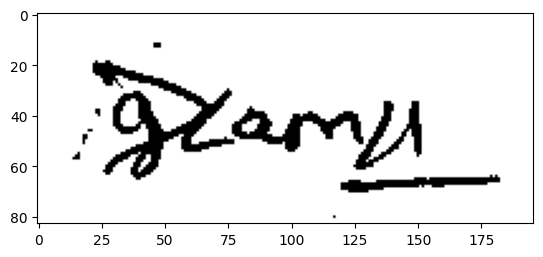

In [ ]:
target_size = (128, 128)

os.chdir('/content/drive/MyDrive/Signature similarity search/samples')

reference_image = '2_G1.png'

image = tf.keras.preprocessing.image.load_img(reference_image)

image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0

plt.imshow(image_array)

In [ ]:
def add_noise(image_array):
  for i in noise_dict:
    noise_h = noise_dict[i]['h']
    noise_w = noise_dict[i]['w']
    noise_c = noise_dict[i]['c']
    noise_array = noise_dict[i]['i']

    img_h_max = image_array.shape[0]
    img_w_max = image_array.shape[1]

    rand = random.randint(0, 1)
    if rand == 0:
      noise_h_start = 0
      img_h_start = random.randint(0, img_h_max - 1)
    else:
      noise_h_start = random.randint(0, noise_h - 1)
      img_h_start = 0

    rand = random.randint(0, 1)
    if rand == 0:
      noise_w_start = 0
      img_w_start = random.randint(0, img_w_max - 1)
    else:
      noise_w_start = random.randint(0, noise_w - 1)
      img_w_start = 0

    for j in range(min(noise_h - noise_h_start, img_h_max - img_h_start)):
      for k in range(min(noise_w - noise_w_start, img_w_max - img_w_start)):
        for l in range(noise_c):
          # print(f"{j}, {k}, {l}")
          image_array[img_h_start + j][img_w_start + k][l] = max(0, image_array[img_h_start + j][img_w_start + k][l] - noise_array[noise_h_start + j][noise_w_start + k][l])

  return image_array

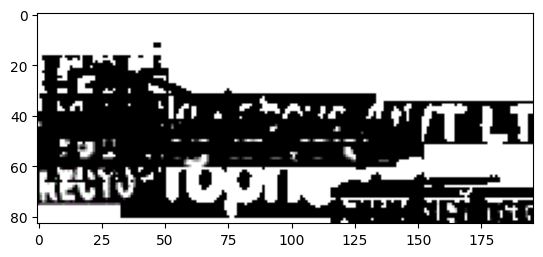

In [ ]:
target_size = (128, 128)

os.chdir('/content/drive/MyDrive/Signature similarity search/samples')

reference_image = '2_G1.png'

image = tf.keras.preprocessing.image.load_img(reference_image)

image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0

image_array = add_noise(image_array)

plt.imshow(image_array)


# Retraining

In [ ]:
os.chdir('/content/drive/MyDrive/Signature similarity search')

# model = tf.keras.models.load_model('Model256.keras') #Overfitting on dataset

base_model = tf.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

base_model.trainable = False

n=len(base_model.layers)
base_model.layers[n-1].trainable=True
# base_model.layers[n-2].trainable=True
# base_model.layers[n-3].trainable=True
# base_model.layers[n-4].trainable=True

encoder = tf.keras.models.Sequential([
    # tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Activation('relu'),
    #tf.keras.layers.Dropout(0.1),

    # tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Activation('relu'),
    # tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
])

model = tf.keras.Sequential([
    base_model,
    #tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    encoder,
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4, decay=1e-6),
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional) │ (None, 4, 4, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256)            │     4,195,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,424,705 (28.32 MB)

 Trainable params: 4,195,329 (16.00 MB)

 Non-trainable params: 3,229,376 (12.32 MB)

In [ ]:
os.chdir('/content/drive/MyDrive/Datasets/')

organized_dataset_path = os.path.join(os.getcwd(), 'signature-verification-organized')
train_dataset_path = os.path.join(organized_dataset_path, 'Train')
test_dataset_path = os.path.join(organized_dataset_path, 'Test')

train_validation_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    # brightness_range = (0.8, 1.2),
    shear_range = 0.2,
    zoom_range = (0.8, 1.2),
    # channel_shift_range= 20,
    fill_mode = 'nearest',
    preprocessing_function = add_noise
)

batch_size_train = 32
batch_size_valid = 16

train_data_generator = train_validation_data_generator.flow_from_directory(
    train_dataset_path,
    target_size = (128, 128),
    batch_size = batch_size_train,
    class_mode = 'binary',
    subset = 'training'
)

validation_data_generator = train_validation_data_generator.flow_from_directory(
    train_dataset_path,
    target_size = (128, 128),
    batch_size = batch_size_valid,
    class_mode = 'binary',
    subset = 'validation'
)

Found 1320 images belonging to 2 classes.
Found 329 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_data_generator,
    epochs=1000,
    validation_data=validation_data_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    ]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.7033 - loss: 1.0679 - val_accuracy: 0.5866 - val_loss: 2.2099
Epoch 2/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.8761 - loss: 0.7748 - val_accuracy: 0.6565 - val_loss: 1.6260
Epoch 3/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9372 - loss: 0.6742 - val_accuracy: 0.6687 - val_loss: 1.7186
Epoch 4/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.9490 - loss: 0.6252 - val_accuracy: 0.7508 - val_loss: 1.2754
Epoch 5/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9498 - loss: 0.5911 - val_accuracy: 0.7295 - val_loss: 1.3444
Epoch 6/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.9664 - loss: 0.5673 - val_accuracy: 0.7538 - val_loss: 1.3855
Epoch 7/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.9697 - loss: 0.5430 - val_accuracy: 0.8055 - val_loss: 1.1718
Epoch 8/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9598 - loss: 0.5402 - val_accu

In [ ]:
History = model.history

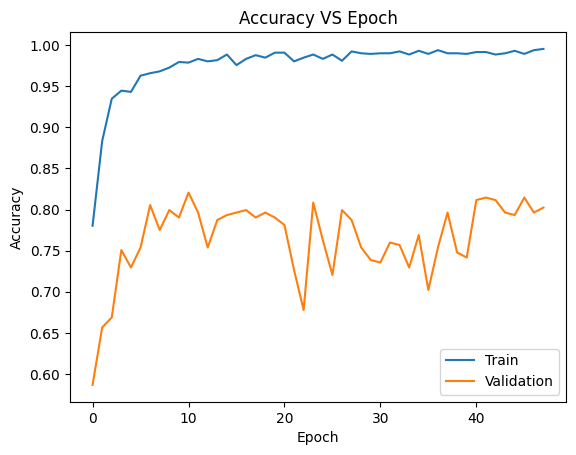

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Accuracy VS Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

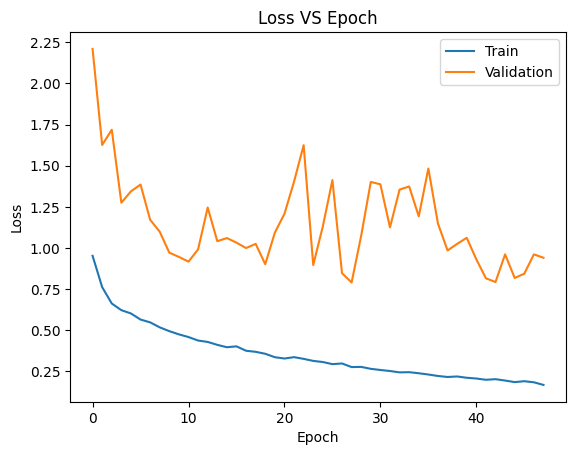

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Loss VS Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
batch_size_test = 32

test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255).flow_from_directory(test_dataset_path,
                                                                    target_size = (128,128),
                                                                    batch_size = batch_size_test,
                                                                    class_mode = 'binary')

Found 500 images belonging to 2 classes.


In [ ]:
model.evaluate(test_data_generator)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 640ms/step - accuracy: 0.9978 - loss: 0.2558


[0.2558312714099884, 0.9959999918937683]

In [ ]:
test_data_generator.shuffle = False
test_data_generator.reset()

y_pred = model.predict(test_data_generator)
y_pred_labels = (y_pred >= 0.5).astype(int)

y_true = test_data_generator.classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 642ms/step


In [ ]:
cm = confusion_matrix(y_true, y_pred_labels)
print(cm)

[[246   2]
 [  0 252]]


In [ ]:
cr = classification_report(y_true, y_pred_labels)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       248
           1       0.99      1.00      1.00       252

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



In [ ]:
os.chdir('/content/drive/My Drive/')
model.save('Model256-noise.keras')